# Understanding CUPED

*An in depth guide to the state-of-the art variance reduction technique in A/B tests*

During my PhD, I spent a lot of time learning and applying causal inference methods to experimental and observational data. However, I was completely clueless when I first heard of **CUPED** (Controlled-Experiment using Pre-Experiment Data), a technique to increase the power of randomized controlled trials in A/B tests.

What really amazed me was the popularity of the algorithm in the industry. CUPED was first introduced by Microsoft researchers [Deng, Xu, Kohavi, Walker (2013)](https://dl.acm.org/doi/abs/10.1145/2433396.2433413) and has been widely used in companies such as [Netflix](https://www.kdd.org/kdd2016/papers/files/adp0945-xieA.pdf), [Booking](https://booking.ai/995d186fff1d), [Meta](https://research.facebook.com/blog/2020/10/increasing-the-sensitivity-of-a-b-tests-by-utilizing-the-variance-estimates-of-experimental-units/), [Airbnb](https://arxiv.org/abs/2112.13299), [TripAdvisor](https://www.tripadvisor.com/engineering/reducing-a-b-test-measurement-variance-by-30/), [DoorDash](https://doordash.engineering/2020/10/07/improving-experiment-capacity-by-4x/), [Faire](https://craft.faire.com/how-to-speed-up-your-a-b-test-outlier-capping-and-cuped-8c9df21c76b), and many others. While digging deeper into it, I noticed a similarity with some causal inference methods I was familiar with, such as [Difference-in-Differences](https://diff.healthpolicydatascience.org/). I was curious and decided to dig deeper.

In this post, I will present CUPED and try to compare it against other causal inference methods.

## Example

Let's assume we are a firm that is testing an **ad campaign** and we are interested in understanding whether it increases revenue or not. We randomly split a set of users into a treatment and control group and we show the ad campaign to the treatment group. Differently from the standard A/B test setting, assume we observe users also before the test.

We can now generate the simulated data, using the data generating process `dgp_cuped()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_cuped

In [3]:
df = dgp_cuped().generate_data()
df.head()

,i,ad_campaign,revenue0,revenue1
0,1,0,5.315635,8.359304
1,2,1,2.977799,7.751485
2,3,0,4.693796,9.025253
3,4,0,5.827975,8.540667
4,5,0,5.230095,8.910165


We have informations on 1000 individuals indexed by `i` for whom we observe the revenue generated pre and post treatment, `revenue0` and `revenue1` respectively, and whether they have been exposed to the `ad_campaign`.

### Difference in Means

In randomized experiments or A/B tests, **randomization** allows us to estimate the average treatment effect using a simple difference in means. We can just compare the average outcome post-treatment $Y_1$ (`revenue`) across control and treated units and randomization guarantees that this difference is due to the treatment alone, in expectation.

$$
\widehat {ATE}^{simple} = \bar Y_{t=1, d=1} - \bar Y_{t=1, d=0}
$$

Where the bar indicates the average over individuals. In our case, we compute the average revenue post ad campaign in the treatment group, minus the average revenue post ad campaign in the control group.

In [4]:
np.mean(df.loc[df.ad_campaign==True, 'revenue1']) - np.mean(df.loc[df.ad_campaign==False, 'revenue1'])

1.7914301325347406

The estimated treatment effect is 1.79, very close to the **true value** of 2. We can obtain the same estimate by regressing the post-treatment outcome `revenue1` on the treatment indicator `ad_campaign`.

$$
Y_{i, t=1} = \alpha + \beta D_i + \varepsilon_i
$$

Where $\beta$ is the coefficient of interest.

In [5]:
smf.ols('revenue1 ~ ad_campaign', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.2995,0.211,39.398,0.000,7.881,8.718
ad_campaign,1.7914,0.301,5.953,0.000,1.194,2.389


This estimator is **unbiased**, which means it delivers the correct estimate, on average. However, it can still be improved: we could **decrease its variance**. Decreasing the variance of an estimator is extremely important since it allows us to 

- **detect smaller effects**
- detect the same effect, but with a **smaller sample size**

In general, an estimator with a smaller variance allows us to run tests with higher [**power**](https://en.wikipedia.org/wiki/Power_of_a_test), i.e. ability to detect smaller effects.

Can we improve the power of our AB test? Yes, with CUPED (among other methods).

## CUPED

The **idea** of CUPED is the following. Suppose you are running an AB test and $Y$ is the outcome of interest (`revenue` in our example) and the binary variable $D$ indicates whether a single individual has been treated or not (`ad_campaign` in our example).

Suppose you have access to another random variable $X$ which is **not affected** by the treatment and has known expectation $\mathbb E[X]$. Then define

$$
\hat Y^{cuped}_{1} = \bar Y_1 - \theta \bar X + \theta \mathbb E [X]
$$

where $\theta$ is a scalar. This estimator is an **unbiased** estimator for $\mathbb E[Y]$ since in expectation the two last terms cancel out. However, the variance of $\hat Y^{cuped}_{1}$ is 

$$
\begin{aligned}
\text{Var} \left( \hat Y^{cuped}_{1} \right) &= \text{Var} \left( \bar Y_1 - \theta \bar X + \theta \mathbb E [X] \right) = \newline
&= \text{Var} \left( Y_1 - \theta X \right) / n = \newline
&= \Big( \text{Var} (Y_1) + \theta^2 \text{Var} (X) - 2 \theta \text{Cov} (X,Y) \Big) / n
\end{aligned}
$$

Note that the variance of $\hat Y^{cuped}_{1}$ is minimized for 

$$
\theta^* = \frac{\text{Cov} (X,Y)}{\text{Var} (X)} 
$$

Which is the **OLS** estimator of a linear regression of $Y$ on $X$. Substituting $\theta^*$ into the formula of the variance of $\hat Y^{cuped}_{1}$ we obtain

$$
\text{Var} \left( \hat Y^{cuped}_{1} \right) = \text{Var} (\bar Y) (1 - \rho^2)
$$

where $\rho$ is the **correlation** between $Y$ and $X$. Therefore, the higher the correlation between $Y$ and $X$, the higher the variance reduction of CUPED.

We can then **estimate the average treatment effect**as the average difference in the transformed outcome between the control and treatment group.

$$
\begin{aligned}
\widehat {ATE}^{cuped} &= \hat Y^{cuped}_{1} (D=1) - \hat Y^{cuped}_{1}(D=0) = \newline
&= \big( \bar Y_1 - \theta \bar X + \theta \mathbb E [X] \ \big| \ D = 1 \big) - \big( \bar Y_1 - \theta \bar X + \theta \mathbb E [X] \ \big| \ D = 0 \big) = \newline
&= \big( \bar Y_1 - \theta \bar X \ \big| \ D = 1 \big) - \big( \bar Y_1 - \theta \bar X \ \big| \ D = 0 \big)
\end{aligned}
$$

Note that $\mathbb E[X]$ cancels out when taking the difference. Therefore, it is sufficient to compute 

$$
\hat Y_{cuped,1}' = \bar Y_1 - \theta \bar X
$$

This is not an unbiased estimator of $\mathbb E[Y]$ but still delivers an unbiased estimator of the average treatment effect.

### Optimal X

What is the **optimal choice** for the control variable $X$?

We know that $X$ should have the following **properties**:

- not affected by the treatment
- as correlated with $Y_1$ as possible

The authors of the paper suggest using the **pre-treatment outcome** $Y_{0}$ since it gives the most reduction in variance in practice. 

Therefore, **in practice**, we can compute the CUPED estimate of the average treatment effect as follows:

1. Regress $Y_1$ on $Y_0$ and estimate $\hat \theta$
2. Compute $\hat Y^{cuped}_{1} = \bar Y_1 - \hat \theta \bar Y_0$
3. Compute the difference of $\hat Y^{cuped}_{1}$ between treatment and control group

Equivalently, we can compute $\hat Y^{cuped}_{1}$ at the individual level and then regress it on the treatment dummy variable $D$.

### Back To The Data

Let's compute the CUPED estimate for the treatment effect, one step at the time. First, let's estimate $\theta$.

In [6]:
theta = smf.ols('revenue1 ~ revenue0', data=df).fit().params[1]

Now we can compute the transformed outcome $\hat Y^{cuped}_{1}$.

In [7]:
df['revenue1_cuped'] = df['revenue1'] - theta * (df['revenue0'] - np.mean(df['revenue0']))

Lastly, we estimate the treatment effect as a difference in means, with the transformed outcome $\hat Y^{cuped}_{1}$.

In [8]:
smf.ols('revenue1_cuped ~ ad_campaign', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.2259,0.143,57.677,0.000,7.943,8.509
ad_campaign,1.9415,0.204,9.529,0.000,1.537,2.346


The standard error is 33% smaller!

### Equivalent Formulation

An alternative but algebraically **equivalent** way of obtaining the CUPED estimate is the folowing

1. Regress $Y_1$ on $Y_0$ and compute the residuals $\tilde Y_1$
2. Compute $\hat Y^{cuped}_{1} = \tilde Y_1 + \bar Y_1$
3. Compute the difference of $\hat Y^{cuped}_{1}$ between treatment and control group

Step (3) is the same as before but (1) and (2) are different. This procedure is called **partialling out** and the algebraic equivalence is guaranteed by the [Frisch-Waugh-Lowell Theorem](https://towardsdatascience.com/59f801eb3299).

Let's check if we indeed obtain the same result.

In [9]:
df['revenue1_tilde'] = smf.ols('revenue1 ~ revenue0', data=df).fit().resid + np.mean(df['revenue1'])

In [10]:
smf.ols('revenue1_tilde ~ ad_campaign', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.2259,0.143,57.677,0.000,7.943,8.509
ad_campaign,1.9415,0.204,9.529,0.000,1.537,2.346


Yes! The regression table is exactly identical.

## CUPED vs Other

CUPED seems to be a very powerful procedure but it is remindful of at least a couple of other methods.

1. Autoregression or regression with control variables
2. [Difference-in-Differences](https://diff.healthpolicydatascience.org/)

Are these methods the same or is there a difference? Let's check.

### Autoregression

The **first question** that came to my mind when I first saw CUPED was "*is CUPED just the simple difference with an additional control variable?*". Or equivalently, is CUPED equivalent to running the following regression

$$
Y_{i, t=1} = \alpha + \beta D_i + \gamma Y_{i, t=0} + \varepsilon_i
$$

and estimating $\gamma$ via least squares?

In [11]:
smf.ols('revenue1 ~ revenue0 + ad_campaign', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.9939,0.603,3.304,0.001,0.796,3.192
revenue0,1.2249,0.114,10.755,0.000,0.999,1.451
ad_campaign,1.9519,0.205,9.529,0.000,1.545,2.358


The estimated coefficient is very similar to the one we obtained with CUPED and also the standard error is very close. However, they are not exactly the same. 

If you are familiar with the [Frisch-Waugh-Lowell Theorem](https://towardsdatascience.com/59f801eb3299), you might wonder why the two procedures are **not equivalent**. The reason is that with CUPED we are partialling out only $Y$, while the FWL theorem holds when we are partialling out either X or both X and Y.

### Diff-in-Diffs

The **second question** that came to my mind was "i*s CUPED just difference-in-differences?*". [Difference-in-Differences](https://diff.healthpolicydatascience.org/) (or diff-in-diffs, or DiD) is an estimator that computes the treatment effect as a **double-difference** instead of a single one: pre-post and treatment-control instead of just treatment-control. 

$$
\widehat {ATE}^{DiD} = \big( \bar Y_{t=1, d=1} - \bar Y_{t=1, d=0} \big) - \big( \bar Y_{t=0, d=1} - \bar Y_{t=0, d=0} \big)
$$

This method was initially introduced in the 19th century to estimate the causes of a Cholera epidemic in London. The main advantage of diff-in-diff is that it allows to estimate the average treatment effect also when randomization is not perfect and the treatment and control group are not comparable. The **key assumption** that is needed is that these difference between the treatment and control group is constant over time. By taking a double difference, we difference it out.

Let's check how diff-in-diff works empirically. The most common way to compute the diff-in-diff estiamtor is to first reshape the data in a **long format** or **panel format** (one observation is an individual $i$ at time period $t$) and then to regress the outcome $Y$ on the full interaction between the post-treatment dummy $T$ and the treatment dummy $D$.

$$
Y_{i,t} = \alpha + \beta D_i + \gamma \mathbb I (t=1) + \delta D_i * \mathbb I (t=1) + \varepsilon_{i,t}
$$

The estimator of the average treatment effect is the coefficient of the interaction coefficient, $\delta$.

In [12]:
df_long = pd.wide_to_long(df, stubnames='revenue', i='i', j='t').reset_index()
df_long.head()

,i,t,revenue1_tilde,ad_campaign,revenue1_cuped,revenue
0,1,0,8.093744,0,8.093744,5.315635
1,2,0,10.164644,1,10.164644,2.977799
2,3,0,9.472203,0,9.472203,4.693796
3,4,0,7.688063,0,7.688063,5.827975
4,5,0,8.742618,0,8.742618,5.230095


The long dataset is now indexed by individuals $i$ and time $t$. We can now run the diff-in-diffs regression.

In [13]:
smf.ols('revenue ~ t * ad_campaign', data=df_long).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.1481,0.174,29.608,0.000,4.805,5.491
t,3.1514,0.246,12.816,0.000,2.666,3.636
ad_campaign,-0.1310,0.248,-0.527,0.599,-0.621,0.359
t:ad_campaign,1.9224,0.351,5.473,0.000,1.230,2.615


The estimated coefficient is close to the true value, 2, but the standard errors are bigger than the ones obtained with all other methods (0.35 >> 0.2). What did we miss? We didn't **cluster the standard errors**! 

I won't go in detail here on what standard error clustering means, but the intuition is the following. The `statsmodels` package by default computes the standard errors assuming that outcomes are **independent** across observations. This assumption is unlikely to be true in this setting where we observe individuals over time and we are trying to exploit this information. Clustering allows for **correlation** of the outcome variable within clusters. In our case, it makes sense (even without knowing the data generating process) to cluster the standard errors at the individual levels, allowing the outcome to be correlated over time for an individual $i$.

In [14]:
smf.ols('revenue ~ t * ad_campaign', data=df_long)\
    .fit(cov_type='cluster', cov_kwds={'groups': df_long['i']})\
    .summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,5.1481,0.139,37.056,0.000,4.876,5.420
t,3.1514,0.128,24.707,0.000,2.901,3.401
ad_campaign,-0.1310,0.181,-0.724,0.469,-0.486,0.224
t:ad_campaign,1.9224,0.209,9.208,0.000,1.513,2.332


Clustering standard errors at the individual level we obtain standard errors that are comparable to the previous estimates ($\sim 0.2$).

Note that diff-in-diffs is **equivalent to CUPED** when we assume the CUPED coefficient $\theta=1$.

In [25]:
df['revenue1_cuped2'] = df['revenue1'] - 1 * (df['revenue0'] - np.mean(df['revenue0']))
smf.ols('revenue1_cuped2 ~ ad_campaign', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.2353,0.145,56.756,0.000,7.947,8.523
ad_campaign,1.9224,0.207,9.274,0.000,1.511,2.334


Indeed, we obtain the same exact coefficient and almost identical standard errors!

### Comparison

Which method is better? From what we have seen so far, all methods seem to deliver an accurate estimate, but the simple difference has a larger standard deviation.

Let's now compare all the methods we have seen so far via **simulation**. We simulate the data generating process `dgp_cuped()` 1000 times and we save the estimated coefficient of the following methods:

1. Simple difference
2. Autoregression
3. Diff-in-diffs
4. CUPED

In [39]:
def simulate(dgp, K=300, x='revenue0'):
    
    # Initialize coefficients
    results = pd.DataFrame(columns=['k', 'Estimator', 'Estimate'])
    
    # Compute coefficients
    for k in range(K):
        temp = pd.DataFrame({'k': [k] * 4, 
                             'Estimator': ['1. Diff ', '2. Areg ', '3. DiD  ', '4. CUPED'], 
                             'Estimate': [0] * 4})
        
        # Draw data
        df = dgp.generate_data(seed=k)

        # Single diff
        temp['Estimate'][0] = smf.ols('revenue1 ~ ad_campaign', data=df).fit().params[1]
        
        # Autoregression
        temp['Estimate'][1] = smf.ols(f'revenue1 ~ ad_campaign + {x}', data=df).fit().params[1]
        
        # Double diff
        df_long = pd.wide_to_long(df.dropna(), stubnames='revenue', i='i', j='t').reset_index()
        temp['Estimate'][2] = smf.ols('revenue ~ ad_campaign * t', data=df_long)\
            .fit(cov_type='cluster', cov_kwds={'groups': df_long['i']}).params[3]
        
        # Cuped
        df['revenue1_tilde'] = smf.ols(f'revenue1 ~ {x}', data=df).fit().resid + np.mean(df['revenue1'])
        temp['Estimate'][3] = smf.ols('revenue1_tilde ~ ad_campaign', data=df).fit().params[1]
                
        # Combine estimates
        results = pd.concat((results, temp))
    
    return results.reset_index(drop=True)

In [36]:
results = simulate(dgp=dgp_cuped())

Let's plot the distribution of the estimated parameters.

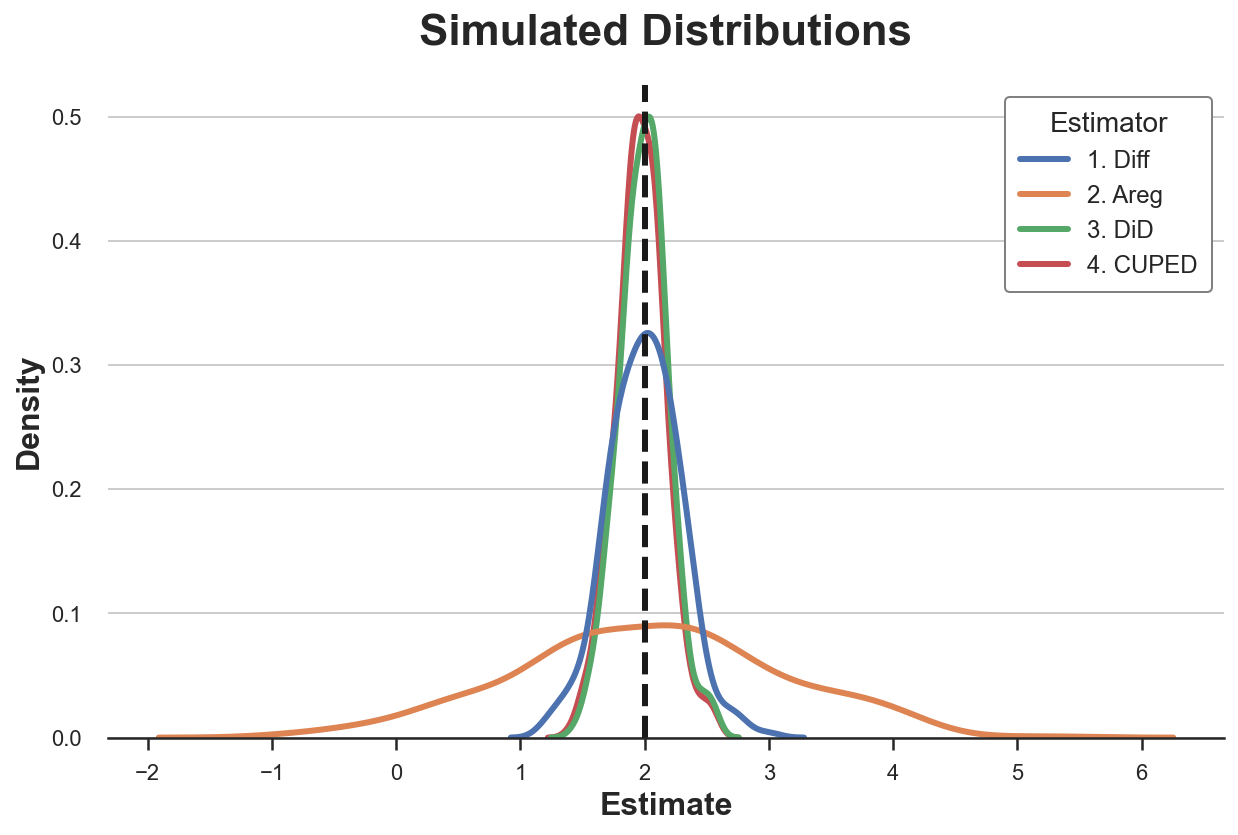

In [37]:
sns.kdeplot(data=results, x="Estimate", hue="Estimator");
plt.axvline(x=2, c='k', ls='--');
plt.title('Simulated Distributions');

We can also tabulate the simulated mean and standard deviation of each estimator.

In [38]:
results.groupby('Estimator').agg(mean=("Estimate", "mean"), std=("Estimate", "std"))

,mean,std
Estimator,,
1. Diff,1.999626,0.291497
2. Areg,2.034145,1.063968
3. DiD,1.993494,0.197638
4. CUPED,1.971853,0.198145


All estimators seem **unbiased**: the average values are all close to the true value of 2. Moreover, all estimators have a very similar standard deviation, apart from the single-difference estimator!

### Always Identical?

Are the estimators always identical, or is there some difference among them? 

We could check many different departures from the original data generating process. For simplicity, I will consider only one here: **imperfect randomization**. Other tweaks of the data generating process that I considered are:

- pre-treatment missing values
- additional covariates / control variables
- multiple pre-treatment periods
- heterogeneous treatment effects

and combinations of them. However, I found imperfect randomization to be the most informative example.

Suppose now that **randomization was not perfect** and two groups are not identical. In particular, if the data generating process is

$$
Y_{i,t} = \alpha + \beta D_i + \gamma \mathbb I (t=1) + \delta D_i * \mathbb I (t=1) + u_i + \varepsilon_{i,t}
$$

assume that $\beta \neq 0$.

In [20]:
results_beta1 = simulate(dgp=dgp_cuped(beta=1))

Let's plot the distribution of the estimated parameters.

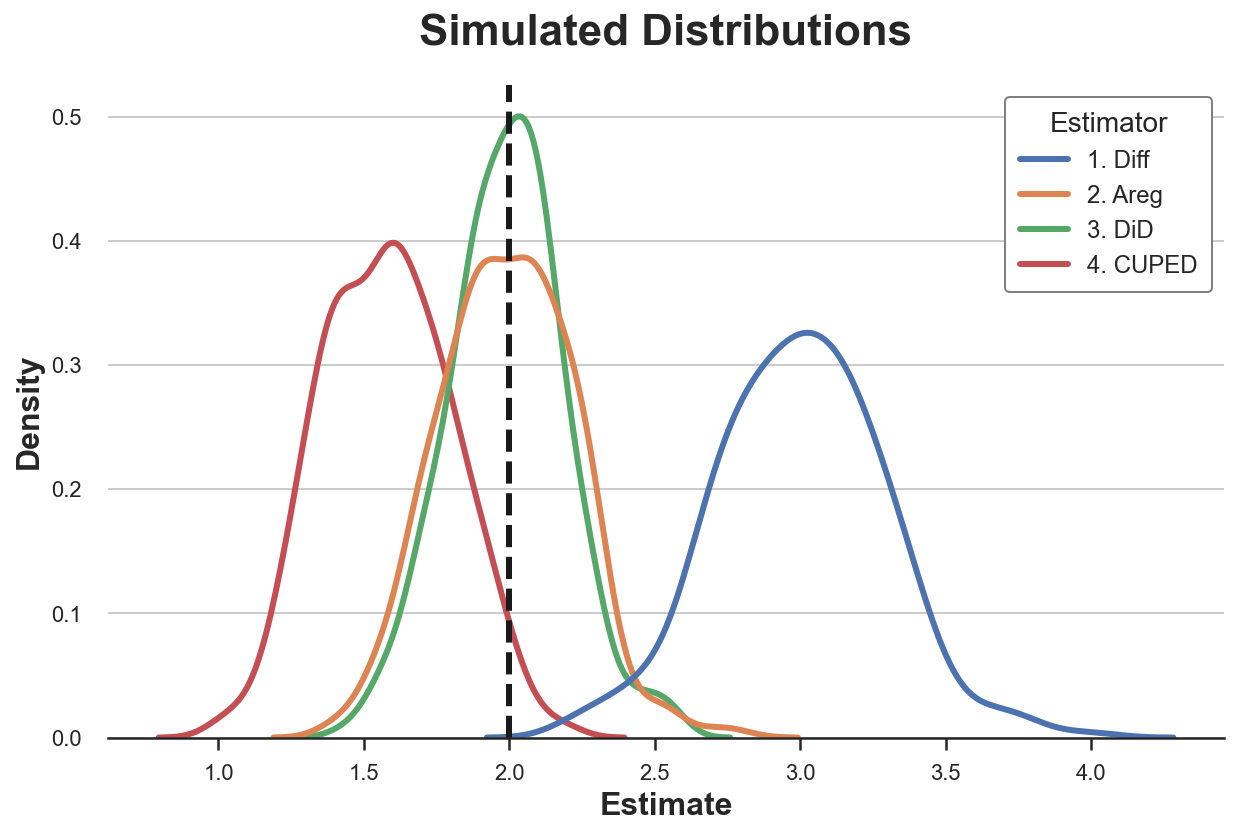

In [21]:
sns.kdeplot(data=results_beta1, x="Estimate", hue="Estimator");
plt.axvline(x=2, c='k', ls='--');
plt.title('Simulated Distributions');

In [22]:
results_beta1.groupby('Estimator').agg(mean=("Estimate", "mean"), std=("Estimate", "std"))

,mean,std
Estimator,,
1. Diff,2.999626,0.291497
2. Areg,1.991508,0.227065
3. DiD,1.993494,0.197638
4. CUPED,1.577712,0.221448


With imperfect treatment assignment, both difference-in-differences and autoregression are unbiased for the true treatment effect, however diff-in-diffs is more efficient. Both CUPED and simple difference are **biased** instead. Why?

Diff-in-diffs explicily controls for **systematic differences** between treatment and control group that are **constant over time**. This is exactly what this estimator was built for. Autoregression performs some sort of matching on the additional covariate, $Y_{t=0}$, effectively controlling for these systematic differences as well, but less efficiently (if you want to know more, I wrote related posts on control variables [here](https://towardsdatascience.com/b63dc69e3d8c) and [here](https://towardsdatascience.com/58b63d25d2ef)). CUPED controls for persistent heterogeneity at the individual level, but not at the treatment assignment level. Lastly, the simple difference estimator does not control for anything.

## Conclusion

In this post, I have analyzed an estimator of average treatment effects in AB testing, very popular in the industry: CUPED. The key idea is that, by exploiting pre-treatment data, CUPED can **achieve a lower variance** by controlling for individual-level variation that is persistent over time. We have also seen that CUPED is closely related but not equivalent to autoregression and difference-in-differences. The differences among the methods clearly emerge when we have imperfect randomization.

An interesting avenue of future research is what happens when we have **a lot of pre-treatment information**, either in terms of time periods or observable characteristics. Scientists from Meta, [Guo, Coey, Konutgan, Li, Schoener, Goldman (2021)](https://proceedings.neurips.cc/paper/2021/hash/488b084119a1c7a4950f00706ec7ea16-Abstract.html), have analyzed this problem in a very recent paper that exploits machine learning techniques to efficiently use this extra information. This approach is closely related to the [Double/Debiased Machine Learning](https://academic.oup.com/ectj/article/21/1/C1/5056401) literature. If you are interested, I wrote two articles on the topic ([part 1](https://towardsdatascience.com/eb767a59975b) and [part 2](https://towardsdatascience.com/bf990720a0b2)) and I might write more in the future.

### References

[1] A. Deng, Y. Xu, R. Kohavi, T. Walker, [Improving the Sensitivity of Online Controlled Experiments by Utilizing Pre-Experiment Data](https://dl.acm.org/doi/abs/10.1145/2433396.2433413) (2013), *WSDM*.

[2] H. Xir, J. Aurisset, [Improving the sensitivity of online controlled experiments: Case studies at Netflix](https://dl.acm.org/doi/abs/10.1145/2939672.2939733) (2013), *ACM SIGKDD*.

[3] Y. Guo, D. Coey, M. Konutgan, W. Li, C. Schoener, M. Goldman, [Machine Learning for Variance Reduction in Online Experiments](https://proceedings.neurips.cc/paper/2021/hash/488b084119a1c7a4950f00706ec7ea16-Abstract.html) (2021), *NeurIPS*.

[4] V. Chernozhukov, D. Chetverikov, M. Demirer, E. Duflo, C. Hansen, W. Newey, J. Robins, [Double/debiased machine learning for treatment and structural parameters](https://academic.oup.com/ectj/article/21/1/C1/5056401) (2018), *The Econometrics Journal*.

[5] M. Bertrand, E. Duflo, S. Mullainathan, [How Much Should We Trust Differences-In-Differences Estimates?](https://academic.oup.com/qje/article/119/1/249/1876068) (2012), *The Quarterly Journal of Economics*.

### Related Articles

- [Double Debiased Machine Learning (part 1)](https://towardsdatascience.com/eb767a59975b)
- [Double Debiased Machine Learning (part 2)](https://towardsdatascience.com/bf990720a0b2)
- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)
- [Understanding Contamination Bias](https://towardsdatascience.com/58b63d25d2ef)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/cuped.ipynb